    Libraries

In [36]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from scipy import optimize as sco

In [37]:
enddate= pd.to_datetime('today').normalize()
startdate = enddate-dt.timedelta(2520)
startdate

Timestamp('2017-12-06 00:00:00')

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed


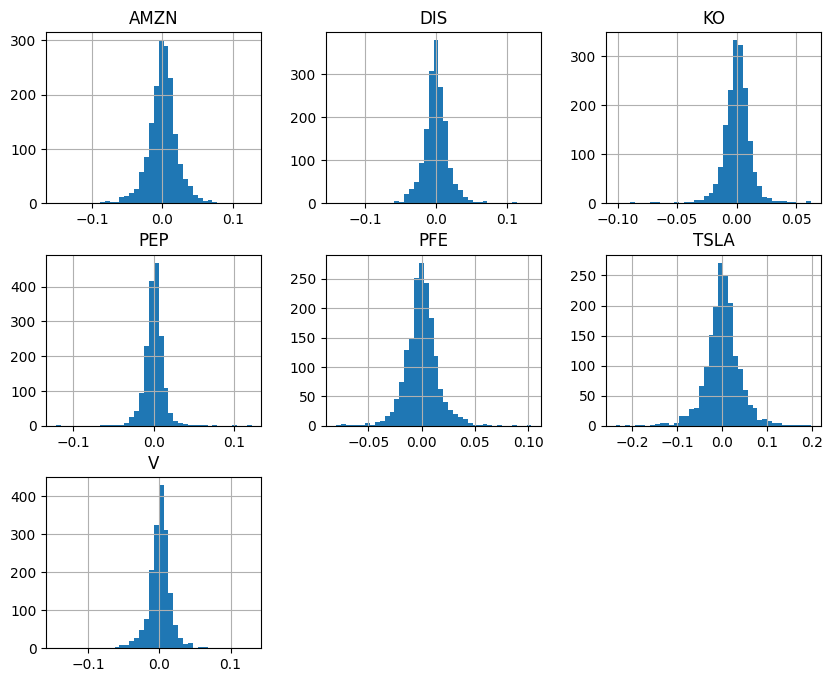

In [38]:
assets = ['KO', 'PFE', 'AMZN','V', 'PEP','DIS','TSLA']
noa = len(assets)
data = yf.download(assets, start=startdate, end=enddate)['Adj Close']
prices = yf.download(assets, period = '2y')['Adj Close'].pct_change()
returns = prices
rets = np.log(data / data.shift(1))
rets.hist(bins=40, figsize=(10, 8));

Class creation of the calculations for mean, variance, and the correlation matrix

In [39]:
# Credit: https://github.com/CCNY-Analytics-and-Quant/Efficient-Frontier-Project-Qetsiyah-Osamwonyi/blob/main/EF_code.ipynb
class Calculations:
    def __init__(self, returns, assets):
        self.returns = returns
        self.assets = assets

    def computation(self):
        self.tbl = pd.DataFrame(index = self.assets)
        self.tbl['Mean'] = returns.mean()
        self.tbl['Variance'] = returns.var()
        return(self.tbl.T)

    def correlation(self):
        self.tbl = pd.DataFrame(index=self.assets)
        self.corr = returns.corr()
        return(self.corr)

corr_mean_var_calc = Calculations(returns = returns, assets=assets)
display(corr_mean_var_calc.computation().T, corr_mean_var_calc.correlation())

,Mean,Variance
KO,0.000348,0.000070
PFE,-0.000678,0.000210
AMZN,0.001466,0.000416
V,0.000763,0.000121
PEP,-0.000014,0.000095
DIS,-0.000043,0.000335
TSLA,0.000930,0.001380


Ticker,AMZN,DIS,KO,PEP,PFE,TSLA,V
Ticker,,,,,,,
AMZN,1.000000,0.347738,0.122060,0.050509,0.083532,0.356794,0.372608
DIS,0.347738,1.000000,0.163854,0.102982,0.171679,0.253215,0.337419
KO,0.122060,0.163854,1.000000,0.670493,0.260523,0.016529,0.351273
PEP,0.050509,0.102982,0.670493,1.000000,0.158679,0.056601,0.252939
PFE,0.083532,0.171679,0.260523,0.158679,1.000000,0.032972,0.165271
TSLA,0.356794,0.253215,0.016529,0.056601,0.032972,1.000000,0.273205
V,0.372608,0.337419,0.351273,0.252939,0.165271,0.273205,1.000000


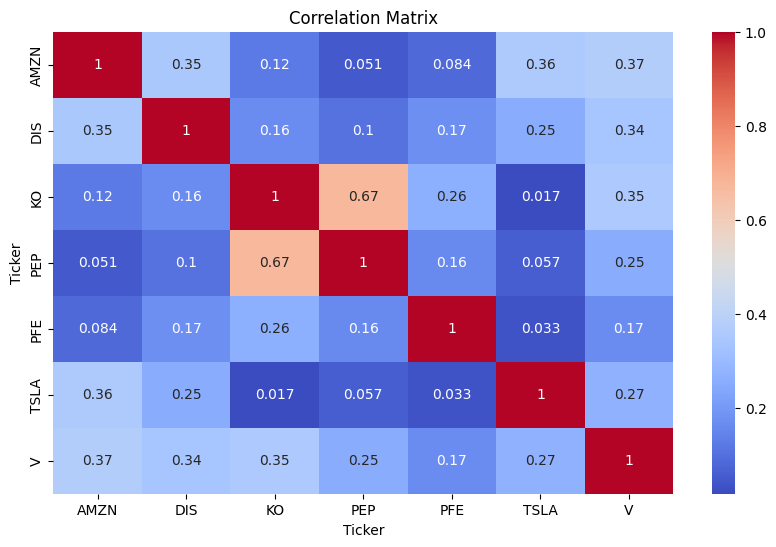

In [40]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_mean_var_calc.correlation(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [41]:
weights = np.random.random(noa)
weights /= np.sum(weights)
print(weights)

[0.11164858 0.11888835 0.11798112 0.23466749 0.02518874 0.16674975
 0.22487597]


In [42]:
def port_ret(weights):
 return np.sum(rets.mean() * weights) * 252

def port_vol(weights):
 return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

    Monte Carlo

In [43]:
prets = []
pvols = []
for p in range (50000):
   weights = np.random.random(noa)
   weights /= np.sum(weights)
   prets.append(port_ret(weights))
   pvols.append(port_vol(weights))
prets = np.array(prets)
pvols = np.array(pvols)


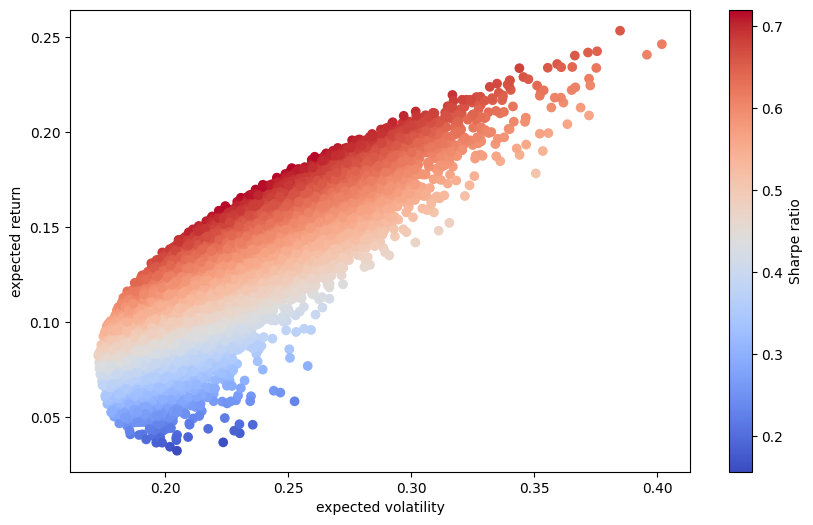

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols,
            marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

In [45]:
def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights)

cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
eweights = np.array(noa * [1. / noa,])


In [46]:
opts = sco.minimize(min_func_sharpe, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons)

opts['x'].round(3)
port_ret(opts['x']).round(3)
port_vol(opts['x']).round(3)
port_ret(opts['x']) / port_vol(opts['x'])

0.7241265453038168

In [47]:
optv = sco.minimize(port_vol, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons)

In [48]:
print(optv['x'].round(3),
port_vol(optv['x']).round(3),
port_ret(optv['x']).round(3),
port_ret(optv['x']) / port_vol(optv['x']))

[0.11  0.047 0.391 0.228 0.208 0.    0.015] 0.172 0.074 0.42776500701835146


In [49]:
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x)-tret},
        {'type': 'eq', 'fun': lambda x: np.sum(x)- 1})

bnds = tuple((0, 1) for x in weights)

trets = np.linspace(0.05, 0.2, 50)
tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)


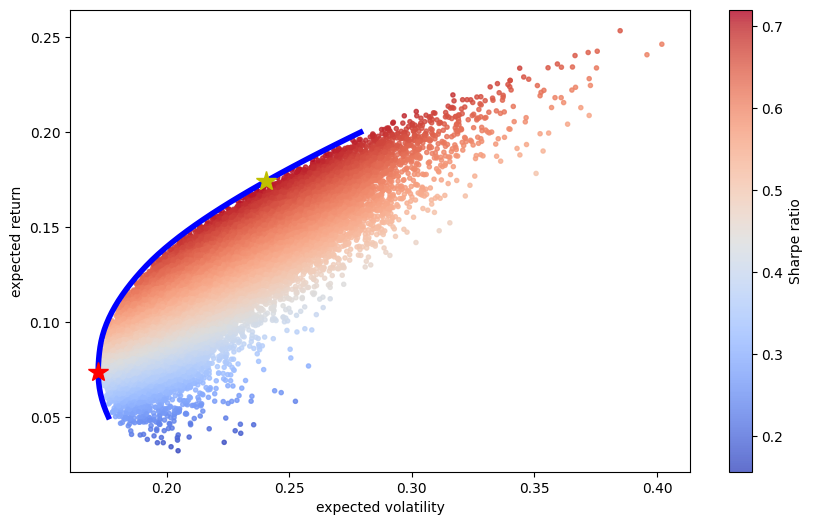

In [50]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols,
            marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']),
         'y*', markersize=15.0)
plt.plot(port_vol(optv['x']), port_ret(optv['x']),
         'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')